<a href="https://colab.research.google.com/github/ldeluigi/supermarket-2077-product-vision/blob/master/Store_Products_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preliminary Operations

In [1]:
!rm -rf sample_data
!gdown --id 1fDr4g4wbnSRkuCYyS3wpuJS7Ax22bVB_ -O all.zip
!unzip -oq all.zip

%matplotlib inline

Downloading...
From: https://drive.google.com/uc?id=1fDr4g4wbnSRkuCYyS3wpuJS7Ax22bVB_
To: /content/all.zip
1.70GB [00:11, 146MB/s]


In [2]:
!pip install opencv-contrib-python==4.4.0.44

     |████████████████████████████████| 55.7 MB 40 kB/s 
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


In [3]:
import scipy.io
import os
from pathlib import Path
import re
import cv2
import matplotlib.pyplot as plt
import numpy as np
import math
import itertools
import shutil
from tqdm.notebook import tqdm
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import cosine
from sklearn.utils.extmath import weighted_mode
from scipy.stats import mode

# Data Visualization Utilities

In [4]:
def show_image(img):
  plt.axis('off')
  plt.imshow(img)

def show_grayscale_image(img):
  show_image(cv2.merge([img, img, img]))

def plot_grid(images, columns, show_axis=False, labels=None):
  if len(images) == 0 or columns <= 0:
    return
  height = 1 + math.ceil(len(images) / columns) * 2
  width = columns * 4
  dpi = max(images[0].shape[0], images[0].shape[1]) // 2
  fig = plt.figure(figsize=(width, height), dpi=dpi)
  fig.subplots_adjust(hspace=0.4)
  for index, img in enumerate(images, start=1):
    if 'float' in img.dtype.str:
      img = (img * 255).astype('uint8')
    sp = fig.add_subplot(math.ceil(len(images) / columns), columns, index)
    if not show_axis:
      plt.axis('off')
    plt.imshow(img)
    if labels is not None:
      l = len(labels)
      sp.set_title(labels[(index-1) % l], fontsize=10)
    else:
      sp.set_title(index, fontsize=10)

def dataset_plot_grid(indexes, columns, dataset, draw_item):
  fig = plt.figure(figsize=(12, 6), dpi=120)
  # fig.subplots_adjust(hspace=0.2)
  for index, i_img in enumerate(indexes, start=1):
    sp = fig.add_subplot(math.ceil(len(indexes) / columns), columns, index)
    row = dataset[i_img]
    draw_item(row, sp)

# Raw image loading

## Utilities to read raw data from disk

In [53]:
training_dirname = 'Training'

def create_class_label(class_index, class_name):
  return class_name

def read_classes():
  mat = scipy.io.loadmat(os.path.join(training_dirname, 'TrainingClassesIndex.mat'))
  raw_classes = list(map(lambda x: x[0], mat['classes'][0]))
  classes = map(lambda x: (x[0], create_class_label(*x)), enumerate(raw_classes, start=1))
  return dict(classes), dict(enumerate(raw_classes, start=1))

def read_training_data(classes):
  images = []
  class_indices = []
  for class_index, class_name in classes.items():
    dirname_images = os.path.join(training_dirname, class_name)
    directory_images = os.fsencode(dirname_images)
    for file in os.listdir(directory_images):
      img = cv2.imread(os.path.join(dirname_images, os.fsdecode(file)))
      img_rgb =  cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      images.append(img_rgb)
      class_indices.append(class_index)
  return images, class_indices

def read_store_data(storename):
  dirname_anno = os.path.join(storename, 'annotation')
  dirname_images = os.path.join(storename, 'images')
  directory_anno = os.fsencode(dirname_anno)
  directory_images = os.fsencode(dirname_images)

  images = []
  class_indices = []
  bounding_boxes = []
  labels = []

  for file in os.listdir(directory_anno):
    filename = os.fsdecode(file)
    if filename.endswith(".mat"): 
      mat = scipy.io.loadmat(os.path.join(dirname_anno, filename))
      number = re.search(r'^anno.(\d+).mat$', filename).group(1)
      img = cv2.imread(os.path.join(dirname_images, number + '.jpg'))

      img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      img_annotation = mat['annotation'][0, 0]
      def clamp(x):
        return max(0, min(1, x))
      def clamp_box(box):
        return list(map(clamp, box))
      bounding_boxes.append(list(map(lambda x: clamp_box(x[0]), img_annotation[0][0])))
      labels.append(list(map(lambda x: str(x[0][0][0]), img_annotation[1][0])))
      classes_in_image = img_annotation[2][0]
      most_frequent_class = mode(classes_in_image)[0][0]
      img_rgb = cv2.GaussianBlur(img_rgb, (3, 3), 0)
      images.append(img_rgb)
      class_indices.append(most_frequent_class)
  return images, class_indices, bounding_boxes, labels

## Prepare products class dictionary

In [6]:
classes, raw_classes = read_classes()

def class_name(class_index):
  return classes[class_index] if class_index >= 0 else None

## Load training raw images

In [7]:
products, products_classes = read_training_data(raw_classes)

## Products visualization

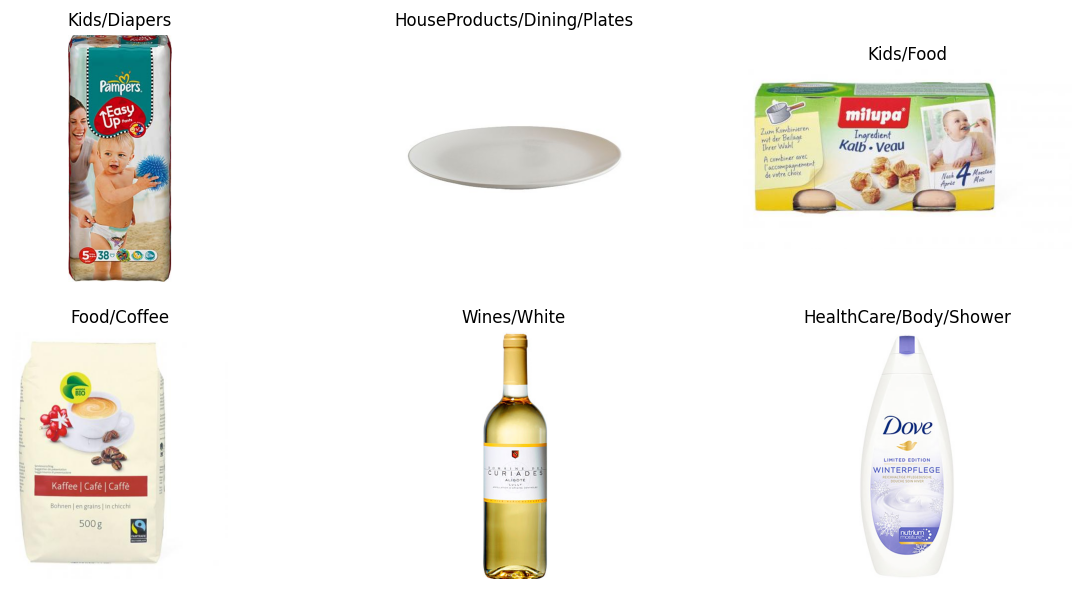

In [8]:
def show_products_with_class(indexes, columns, dataset):
  def show_single_product_with_class(row, sp):
    img, class_index = row
    plt.axis('off')
    plt.imshow(img)
    sp.set_title(class_name(class_index), fontsize=10)
  dataset_plot_grid(indexes, columns, dataset, show_single_product_with_class)

show_products_with_class(np.random.randint(0, len(products), 6), 3, list(zip(products, products_classes)))

# Raw Image preprocessing

## Background removal

Index: 777
Class: Food/Bakery


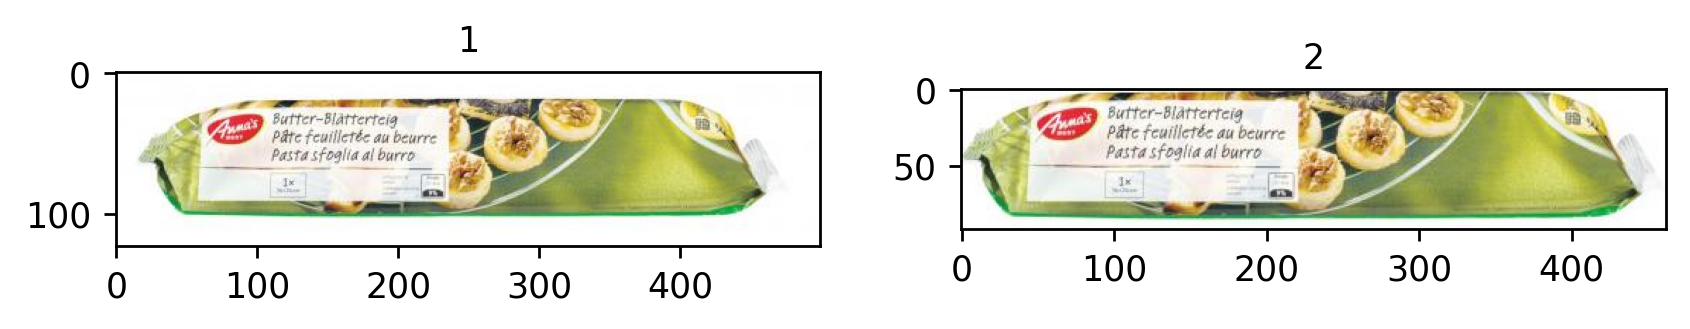

In [9]:
# code taken from https://www.kaggle.com/vadbeg/opencv-background-removal and modified

def remove_background(img, threshold, use_mask=False):
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  _, threshed = cv2.threshold(gray, threshold, 255, cv2.THRESH_BINARY_INV)

  kernel_size = round(max(img.shape[0], img.shape[1]) * 0.02)
  kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
  morphed = cv2.morphologyEx(threshed, cv2.MORPH_CLOSE, kernel)

  cnts = cv2.findContours(morphed, 
                          cv2.RETR_EXTERNAL,
                          cv2.CHAIN_APPROX_SIMPLE)[0] # should be [1] for cv2 version <= 4

  cnts = sorted(cnts, key=cv2.contourArea)

  mask = cv2.drawContours(threshed, [cnts[-1]], 0, [255], cv2.FILLED)

  x, y, w, h = cv2.boundingRect(cnts[-1])

  if use_mask:
    masked_data = cv2.bitwise_and(img, img, mask=mask)
    dst = masked_data[y: y + h, x: x + w]
    r, g, b = cv2.split(dst)
    alpha = mask[y: y + h, x: x + w]

    rgba = [r, g, b, alpha]
    dst = cv2.merge(rgba, 4)
  else:
    dst = img[y: y + h, x: x + w]

  return dst

n = 777
print(f'Index: {n}')
print(f'Class: {class_name(products_classes[n])}')
plot_grid([products[n], remove_background(products[n], 250)], 2, show_axis=True)

## Image resize

Index: 1315
Class: Food/Candy/Chocolate


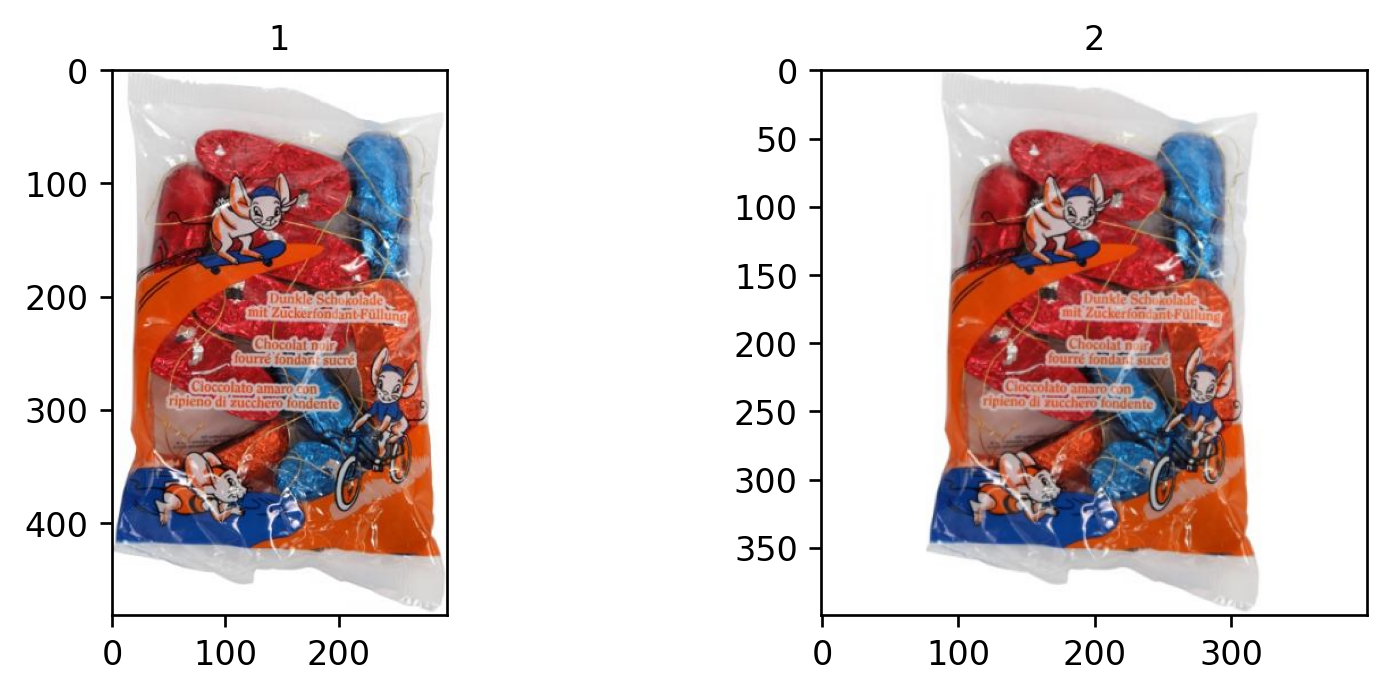

In [10]:
background_color = 255

def resize_image(img, size, color=[background_color, background_color, background_color]):
  target_w, target_h = size
  original_h, original_w, _ = img.shape
  target_ar = target_w / target_h
  original_ar = original_w / original_h

  scale_factor = target_h / original_h if target_ar > original_ar else target_w / original_w
  scaled_w = round(original_w * scale_factor)
  scaled_h = round(original_h * scale_factor)
  scaled_size = (scaled_w, scaled_h)
  resized = cv2.resize(img, scaled_size)

  delta_h = target_h - scaled_h
  delta_w = target_w - scaled_w
  top    = delta_h // 2
  left   = delta_w // 2
  bottom = delta_h - top
  right  = delta_w - left

  return cv2.copyMakeBorder(resized, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)

n = 1315
print(f'Index: {n}')
print(f'Class: {class_name(products_classes[n])}')
image = products[n]
image = remove_background(image, 250)
plot_grid([image, resize_image(image, (400, 400))], 2, show_axis=True)

## Dataset preparation



### Image cleaning

In [11]:
def clean_image(img):
  threshold = 250
  img = remove_background(img, threshold)
  #img = resize_image(img, (128, 128))
  return img

### Prepare dataset

In [12]:
all_products_images = []
for image, class_index in zip(products, products_classes):
  cleaned_image = clean_image(image)
  all_products_images.append(cleaned_image)

print(len(all_products_images))

8421


# Computer vision model

In [13]:
def extract_dense_keypoints(img, extractor):
  step = 8
  for x in range(0, img.shape[1], step):
    for y in range(0, img.shape[0], step):
      yield cv2.KeyPoint(x, y, 4, _class_id=0)

def extract_keypoints(img, extractor):
  return extractor.detect(img)

def extract_descriptors_from_image(img, extractor):
  # method = extract_dense_keypoints
  method = extract_keypoints
  keypoints = list(method(img, extractor))
  _, descriptors = extractor.compute(img, keypoints)
  if descriptors is None:
    return []
  return descriptors

def extract_descriptors(images, extractor, show_progress=False):
  img_iterator = tqdm(images, total=len(images)) if show_progress else images
  return [extract_descriptors_from_image(img, extractor) for img in img_iterator]

extractor = cv2.SIFT_create(nfeatures = 500)
descriptors = extract_descriptors(all_products_images, extractor, show_progress=True)

In [14]:
n = 420
print("Numero di keypoint estratti dall'immagine", n, "=", len(descriptors[n]))
print("Numero di keypoint estratti in totale =", sum([len(d) for d in descriptors]))
print("Numero di componenti del descrittore per ogni keypoint =", len(descriptors[n][0]))
print("Numero di descrittori estratti in media da ogni immagine", np.mean(list(map(lambda d: len(d), descriptors))))

Numero di keypoint estratti dall'immagine 420 = 421
Numero di keypoint estratti in totale = 3430061
Numero di componenti del descrittore per ogni keypoint = 128
Numero di descrittori estratti in media da ogni immagine 407.3222895143095


In [15]:
def create_bovw(descriptors, n_clusters, kmeans_max_iter = 100):
  termination_criteria = (cv2.TERM_CRITERIA_MAX_ITER, kmeans_max_iter, 0.0)
  descriptors_flat = []
  for image_descriptors in descriptors:
    descriptors_flat.extend(image_descriptors)
  descriptors_as_nparray = np.array(descriptors_flat, dtype = np.float32)
  compactness, labels, centers = cv2.kmeans(descriptors_as_nparray, n_clusters, None, termination_criteria, 1, cv2.KMEANS_RANDOM_CENTERS)
  next_first_label_index = 0
  labels_grouped_by_image = []
  for image_descriptors in descriptors:
    curr_labels = []
    count = len(image_descriptors)
    for i in range(next_first_label_index, next_first_label_index + count):
      curr_labels.append(labels[i][0])
    next_first_label_index += count
    labels_grouped_by_image.append(curr_labels)
  return centers, labels_grouped_by_image, compactness

n_clusters = 128
bovw, bovw_labels, compactness = create_bovw(descriptors, n_clusters)

print("Compattezza =", compactness)
print("Numero di visual words =", len(bovw))
print("Numero di descrittori per ogni visual word =", len(bovw[0]))

Compattezza = 266594838711.50684
Numero di visual words = 128
Numero di descrittori per ogni visual word = 128


In [17]:
def normalize_histogram(histogram):
  sum = np.sum(histogram)
  if sum == 0:
    return [0.0] * len(histogram)
  return [x / sum for x in histogram]

def create_histogram_for_image(descriptors, bovw, distance_metric):
  histogram = [0] * len(bovw)
  for d in descriptors:
    nearest = 0
    nearest_distance = distance_metric(d, bovw[0])
    for i in range(1, len(bovw)):
      vw = bovw[i]
      distance = distance_metric(d, vw)
      if distance < nearest_distance:
        nearest = i
        nearest_distance = distance
    histogram[nearest] += 1
  return normalize_histogram(histogram)

def cosine_distance(x, y):
  return cosine(x, y)

def euclidean_distance(x, y):
  return np.linalg.norm(x - y)

def create_histograms(descriptors, bovw, show_progress=False):
  histograms = []
  iterator = descriptors
  if show_progress:
    iterator = tqdm(iterator, total = len(descriptors), desc = "calculating histograms...")
  for descriptors in iterator:
    histogram = create_histogram_for_image(descriptors, bovw, euclidean_distance)
    histograms.append(histogram)
  return histograms

def create_histogram_from_labels(n_clusters, labels):
  histogram = [0] * n_clusters
  for l in labels:
    histogram[l] += 1
  return normalize_histogram(histogram)

def create_histograms_from_labels(n_clusters, labels):
  return [create_histogram_from_labels(n_clusters, l) for l in labels]

histograms = create_histograms_from_labels(n_clusters, bovw_labels)

Numero di keypoint = 500
Histogram: 


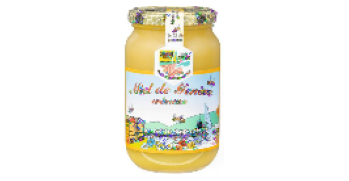

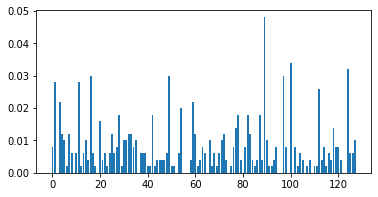

In [18]:
n = np.random.randint(0, len(all_products_images))
img = all_products_images[n]
keypoints = extract_keypoints(img, extractor)
labels = bovw_labels[n]
keypoints_by_label = {}

for k, l in zip(keypoints, labels):
  if l not in keypoints_by_label:
    keypoints_by_label[l] = []
  keypoints_by_label[l].append(k)

for l in keypoints_by_label:
  [r, g, b] = list(np.random.choice(range(256), size=3))
  cv2.drawKeypoints(img, keypoints_by_label[l], img, color = (int(b), int(g), int(r)))

print("Numero di keypoint =", len(keypoints))
show_image(resize_image(img, (256, 128)))
print("Histogram: ")
g = plt.figure(2, figsize=(6, 3))
plt.bar(range(len(histograms[n])), histograms[n])
g.show()

# Testing model on stores

In [68]:
def predict(images, bovw, nn, extractor, show_progress=False):
  image_descriptors = extract_descriptors(images, extractor)
  image_histograms = create_histograms(image_descriptors, bovw, show_progress=show_progress)
  distances, indices = nn.kneighbors(image_histograms)
  return distances, indices

k = 10
nn = NearestNeighbors(n_neighbors=k).fit(histograms) # metric=euclidean_distance

## Tests on cropped store images

In [55]:
store_images_raw, store_classes_raw, bounding_boxes, product_labels = read_store_data('store2')

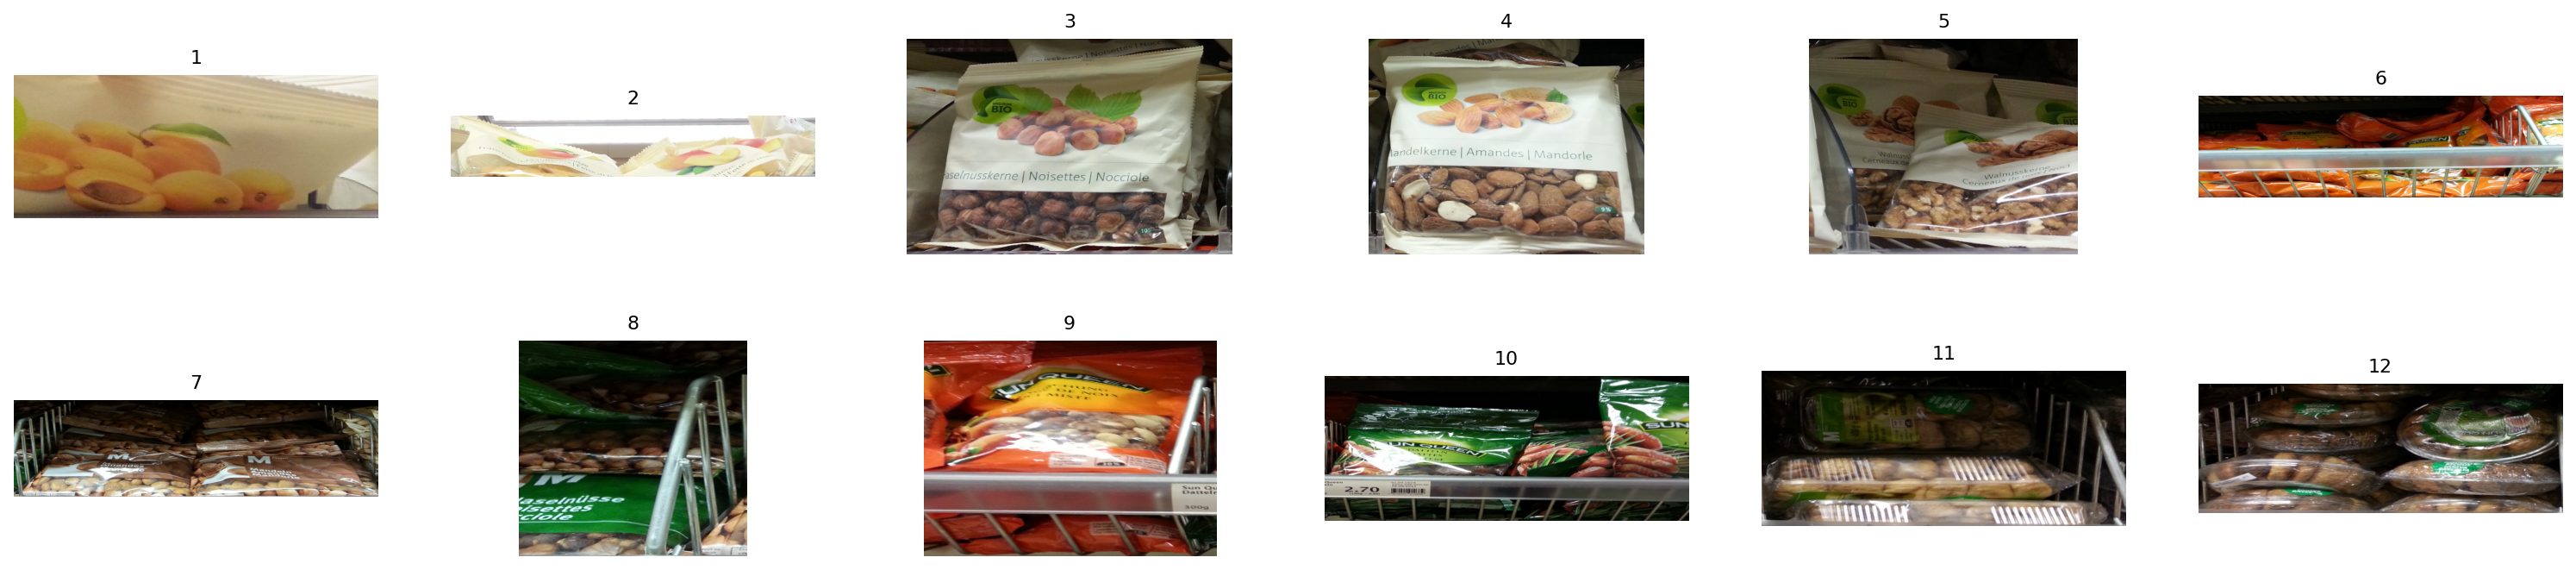

In [71]:
def crop_bounding_boxes(store_images_raw, bounding_boxes, product_labels):
  for store_image_raw, bboxes, labels in zip(store_images_raw, bounding_boxes, product_labels):
    store_image = cv2.resize(store_image_raw, (1280, 720))
    for bbox, label in zip(bboxes, labels):
      [xmin, xmax, ymin, ymax] = bbox
      #print(ymin, ymax, xmin, xmax)
      xmin, xmax = int(xmin * store_image.shape[1]), int(xmax * store_image.shape[1])
      ymin, ymax = int(ymin * store_image.shape[0]), int(ymax * store_image.shape[0])
      yield store_image[ymin:ymax, xmin:xmax], label

product_images = list(crop_bounding_boxes(store_images_raw, bounding_boxes, product_labels))
plot_grid([img for img, _ in product_images][:12], 6)

In [83]:
def accuracy(images, labels):
  total = len(images)
  hit = 0
  miss = 0
  _, predictions = predict(images, bovw, nn, extractor, show_progress=True)
  for label, prediction in zip(labels, predictions):
    print(label, [products_classes[pred] for pred in prediction[:10]])
    if label == products_classes[prediction[0]]:
      hit += 1
    else:
      miss +=1
  return hit, miss, total

accuracy([img for img, _ in product_images[:100]], [label for _, label in product_images[:100]])


30 [58, 64, 57, 1, 54, 63, 64, 29, 70, 64]
45 [47, 67, 18, 18, 41, 19, 6, 20, 58, 75]
69 [33, 72, 72, 20, 72, 30, 9, 18, 66, 66]
79 [9, 19, 9, 45, 16, 50, 31, 26, 20, 18]
88 [18, 67, 18, 20, 33, 66, 22, 19, 26, 9]
90 [43, 13, 26, 35, 35, 24, 9, 27, 24, 22]
82 [60, 20, 67, 72, 5, 9, 79, 12, 3, 28]
68 [72, 60, 22, 5, 6, 30, 22, 45, 69, 22]
76 [9, 28, 22, 9, 22, 10, 67, 26, 26, 22]
35 [72, 13, 69, 69, 67, 69, 12, 10, 3, 24]
-1 [18, 30, 12, 60, 26, 25, 79, 22, 27, 45]
43 [72, 1, 13, 43, 9, 26, 72, 18, 72, 29]
19 [72, 12, 13, 69, 33, 12, 69, 33, 60, 3]
12 [22, 22, 27, 15, 16, 72, 12, 20, 28, 14]
10 [29, 67, 66, 28, 72, 24, 6, 29, 18, 67]
138 [34, 60, 6, 36, 67, 15, 60, 68, 16, 67]
92 [6, 68, 13, 6, 69, 68, 39, 15, 6, 24]
87 [71, 13, 49, 69, 64, 45, 69, 49, 26, 16]
116 [13, 16, 66, 66, 66, 66, 16, 67, 72, 13]
36 [12, 72, 13, 72, 69, 79, 67, 3, 26, 4]
7 [26, 9, 26, 67, 9, 12, 67, 2, 59, 13]
94 [28, 67, 12, 9, 9, 27, 45, 21, 21, 27]
89 [67, 16, 13, 16, 29, 71, 61, 13, 13, 13]
91 [67, 35, 68, 

(0, 100, 100)

## Tests on raw store images

In [ ]:
store_images_raw, store_classes_raw = read_store_data('store2')
limit = 10
n = np.random.randint(0, len(store_images_raw) - limit)
store_images = store_images_raw[n:n+limit]
store_classes = store_classes_raw[n:n+limit]

In [ ]:
def sliding_window(img):
  divide_wh = [(3, 2, 1, 1)]
  for wd, hd, ws, hs in divide_wh:
    window_w = img.shape[1] / wd
    window_h = img.shape[0] / hd
    for hi in range(0, hd, hs):
      y_min = int(hi * window_h)
      y_max = int(y_min + window_h)
      for wi in range(0, wd, ws):
        x_min = int(wi * window_w)
        x_max = int(x_min + window_w)
        #print("Shape:", img.shape, "Window division:", (hd, wd),"Window index: ", (hi, wi), "Pixel range:", (y_min, x_min), (y_max, x_max))
        window = img[y_min:y_max, x_min:x_max]
        yield window

## Performance evaluation


In [ ]:
def predict_with_window(img, bovw, classifier, extractor):
  sw_images = list(sliding_window(img))
  distances, indices = predict(sw_images, bovw, classifier, extractor, show_progress=False)
  #print(indices)
  votes = {}
  for vote_indexes, vote_distances in zip(indices, distances):
    for vote_index, vote_distance in zip(map(lambda i: products_classes[i], vote_indexes), vote_distances):
      if vote_index != 1: # Skip background
        vote_weight = 1 / (vote_distance + 1e-20)
        if vote_index not in votes:
          votes[vote_index] = 0  
        votes[vote_index] += vote_weight
  return sorted(votes.items(), key=lambda item: item[1], reverse=True)[0][0]



predictions = [predict_with_window(img, bovw, nn, extractor) for img in tqdm(store_images, total=len(store_images))]
score = [1 if prediction == store_class else 0 for store_class, prediction in zip(store_classes, predictions)]
print("Accuracy:", sum(score) / len(score))


Accuracy: 0.0


In [ ]:
sw_images = list(sliding_window(store_images[0]))
image_descriptors = extract_descriptors(sw_images, extractor)
image_histograms = create_histograms(image_descriptors, bovw, show_progress=True)
print(image_descriptors)
print(len(image_descriptors[0]))
# print(predict(sw_images, bovw, nn, extractor, show_progress=False))

print(histograms[100])


[array([[  1.,  69., 122., ...,   0.,   0.,   2.],
       [ 35.,  17.,   0., ...,  17.,   3.,  10.],
       [ 99.,  21.,   3., ...,  15.,   0.,   1.],
       ...,
       [ 14.,  78., 128., ...,   0.,   6.,  69.],
       [  3.,   0.,   1., ...,   6.,   1.,   0.],
       [ 78.,   8.,   1., ...,   1.,   0.,   2.]], dtype=float32), array([[39.,  2.,  0., ...,  6.,  2.,  2.],
       [10.,  0.,  0., ..., 10.,  5., 36.],
       [46.,  2.,  0., ...,  0.,  0.,  2.],
       ...,
       [ 1.,  1., 11., ...,  0.,  0.,  4.],
       [ 3., 47., 39., ..., 37.,  6.,  0.],
       [17.,  2.,  6., ...,  5.,  3.,  3.]], dtype=float32), array([[  0.,   0.,  35., ...,   3.,   0.,   0.],
       [  4.,  16.,   6., ...,  28.,   4.,   1.],
       [ 77., 145.,   1., ...,   0.,   0.,   0.],
       ...,
       [ 11.,   0.,   0., ...,  44.,  14.,   5.],
       [  0.,   4.,   2., ...,   0.,   0.,   0.],
       [ 60.,   5.,   0., ...,   0.,   0.,   0.]], dtype=float32), array([[  4.,   6.,  12., ...,   1.,   0.,   0.